In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
import os
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 0:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(f"- {gpu.name}")
else:
    print("No GPUs detected. TensorFlow is running on CPU.")

TensorFlow is using the following GPU(s):
- /physical_device:GPU:0


In [38]:
def load_file(board_file, labels_file):
    with open(board_file, 'r') as f:
        board = []
        for line in f:
            row = []
            for cell in line.strip().split(" "):
                if cell == '-':
                    row.append(9)
                elif cell == 'F':
                    row.append(-1)
                else:
                    try:
                        row.append(int(cell))
                    except ValueError:
                        continue
            board.append(row)

    board = np.array(board)

    labels = []
    with open(labels_file, 'r') as f:
        for line in f:
            row = []
            for cell in line.strip().split(" "):
                row.append(int(cell))
            labels.append(row)

    labels = np.array(labels)
    return board, labels

data_dir = "data 8x8"
labels_dir = "labels 8x8"
X = []
y = []

data_files = sorted(os.listdir(data_dir))
label_files = sorted(os.listdir(labels_dir))

if len(data_files) != len(label_files):
    raise ValueError("The number of data files does not match the number of label files.")

for data_file, label_file in zip(data_files, label_files):
    board, labels = load_file(f"{data_dir}\\{data_file}", f"{labels_dir}\\{label_file}")
    X.append(board)
    y.append(labels)

X = np.array(X)
y = np.array(y)
print(X[0])
print(y[0])

[[ 9  9  9  9  9  9  9  9]
 [ 9  1  1  2  1  1  9  9]
 [ 9  1  0  0  0  1  9  9]
 [ 9  1  0  0  0  1  9  9]
 [ 9  3  1  1  0  1  9  9]
 [ 9  3 -1  3  2  2  9  9]
 [ 9  9  9  9  9  9  9  9]
 [ 9  9  9  9  9  9  9  9]]
[[1 0 1 0 0 1 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0]]


In [39]:
input_shape = (X.shape[1], X.shape[2])
print(X.shape, y.shape)

(69995, 8, 8) (69995, 8, 8)


In [46]:
model = Sequential()

model.add(Flatten(input_shape=input_shape))

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(input_shape[0] * input_shape[1], activation='sigmoid'))

model.add(Reshape((input_shape[0], input_shape[1])))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# model.summary()

In [47]:
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.3638 - binary_accuracy: 0.8570 - val_loss: 0.3182 - val_binary_accuracy: 0.8736
Epoch 2/10
1750/1750 [==============================] - 4s 3ms/step - loss: 0.2966 - binary_accuracy: 0.8823 - val_loss: 0.2824 - val_binary_accuracy: 0.8890
Epoch 3/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2690 - binary_accuracy: 0.8943 - val_loss: 0.2649 - val_binary_accuracy: 0.8962
Epoch 4/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2522 - binary_accuracy: 0.9009 - val_loss: 0.2515 - val_binary_accuracy: 0.9014
Epoch 5/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2422 - binary_accuracy: 0.9044 - val_loss: 0.2464 - val_binary_accuracy: 0.9032
Epoch 6/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2366 - binary_accuracy: 0.9061 - val_loss: 0.2433 - val_binary_accuracy: 0.9039
Epoch 7/10
1750/1750 [==============================

1/1 [==============================] - 0s 32ms/step
(6, 3)
0.92480946


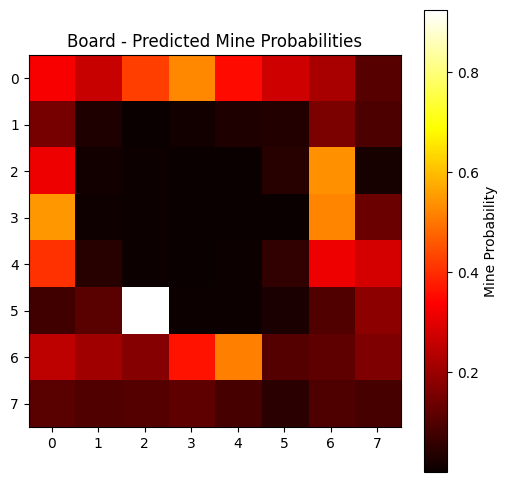

In [48]:
def test_model_on_board(model, board):
    board = np.expand_dims(board, axis=0)
    prediction = model.predict(board)
    predicted_probabilities = prediction[0]
    max_cord = (0, 0)
    max_prediction = 0
    for row, predicted_row in enumerate(predicted_probabilities):
        for col, predicted_cell in enumerate(predicted_row):
            if predicted_cell > max_prediction:
                max_prediction = predicted_cell
                max_cord = (row + 1, col + 1)
    print(max_cord)
    print(max_prediction)
    plt.figure(figsize=(6, 6))
    plt.title(f"Board - Predicted Mine Probabilities")
    plt.imshow(predicted_probabilities, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Mine Probability')
    plt.show()

test_model_on_board(model, X[0])